In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6468407228501440217
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 140574720
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 8988670371393089420
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7"
]


In [12]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

In [13]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [14]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [15]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [16]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [17]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [18]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [19]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [27]:
with open('sniip_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [28]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

In [32]:
optimizer, n = Adam(lr=0.0002), 9

def network(input_shape, ncat, learning_rate=.0002, reg=0.0032, dropout=0.2, seed=1):
    """Define the CNN structure.
    Parameters
    ----------
    input_shape : int
    Shape of the input spectra.
    ncat : int
    Number of categories.
    learning_rate : float
    Learning rate.
    reg : float
    Regularization factor.
    dropout : float
    Dropout rate.
    seed : int
    Seed of initializer.

    Returns
    -------
    model : tensorflow.keras.Model
    A model instance of the network.
    """

    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=n, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=n, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=n, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=n, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)

    #     with backend.name_scope('Dense_Layer'):
    #         X = Flatten()(X)
    #         X = Dense(512, kernel_regularizer=regularizers.l2(reg),
    #                   activation='relu')(X)
    #         X = Dropout(rate=dropout, seed=seed)(X)

    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')

    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [33]:
x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [51]:
def split(trainsize,x,y):
    from sklearn.model_selection import train_test_split
    """This function splits x, y into train, test, cv
    cv and test are equally split"""
    n = trainsize
    # here a, b are (1-n) fraction of x, y
    x_train, a, y_train, b = train_test_split(x, y, train_size=n)
    # now we split a, b into half to get cv and test
    x_cv, x_test, y_cv, y_test = train_test_split(a,b, test_size=0.5)
    return x_train, x_test, x_cv,y_train, y_test, y_cv

# Splitting in 60, 20, 20 

In [38]:
x_train, x_test, x_cv,y_train, y_test, y_cv = split(0.6,x,y)
len(x_train), len(x_test), len(x_cv),len(y_train), len(y_test), len(y_cv)

(46794, 15598, 15598, 46794, 15598, 15598)

In [39]:
model = network((nbins, 1),ncat=y.shape[1])
hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 46794 samples, validate on 15598 samples
Epoch 1/50
46794/46794 [==============================] - 10s 213us/sample - loss: 2.7690 - acc: 0.3909 - val_loss: 2.2156 - val_acc: 0.5371
Epoch 2/50
46794/46794 [==============================] - 8s 174us/sample - loss: 1.9607 - acc: 0.5835 - val_loss: 1.7657 - val_acc: 0.6148
Epoch 3/50
46794/46794 [==============================] - 8s 174us/sample - loss: 1.6450 - acc: 0.6356 - val_loss: 1.5405 - val_acc: 0.6507
Epoch 4/50
46794/46794 [==============================] - 8s 173us/sample - loss: 1.4601 - acc: 0.6593 - val_loss: 1.4055 - val_acc: 0.6635
Epoch 5/50
46794/46794 [==============================] - 8s 174us/sample - loss: 1.3408 - acc: 0.6749 - val_loss: 1.2989 - val_acc: 0.6752
Epoch 6/50
46794/46794 [==============================] - 8s 174us/sample - loss: 1.2538 - acc: 0.6870 - val_loss: 1.2531 - val_acc: 0.6749
Epoch 7/50
46794/46794 [==============================] - 8s 173us/sample - loss: 1.1887 - acc: 0.6943 - val_

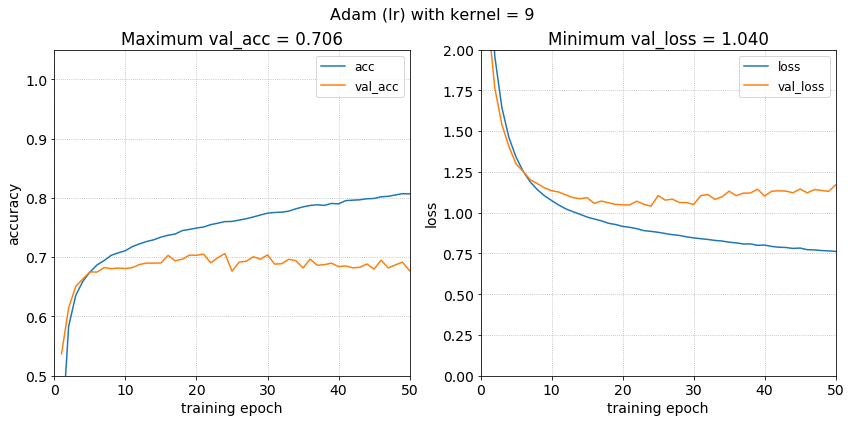

In [43]:
# Plotting epoch vs accuracy
title = "Adam (lr) with kernel = {0}".format(n)
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
fig.suptitle(title, fontsize=16)
nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.set_title('Maximum val_acc = {0:2.3f}'.format(max(hist.history['val_acc'])))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.set_title('Minimum val_loss = {0:2.3f}'.format(min(hist.history['val_loss'])))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

In [44]:
# Print ROC and PR Curve
y_pred = model.predict(x_cv)

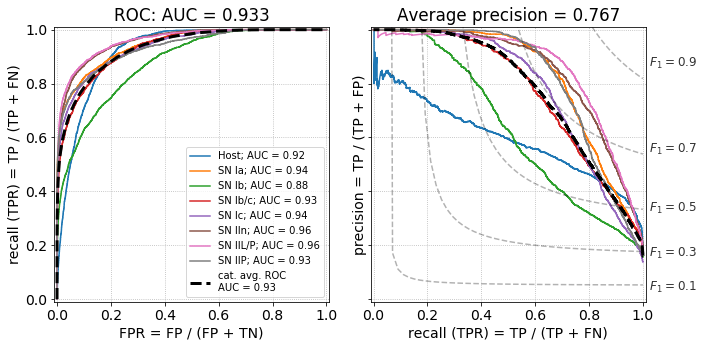

In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_cv[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])

    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')

    pre[i], rec[i], _ = precision_recall_curve(y_cv[:,i], y_pred[:,i])

    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])

ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_cv.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_cv, y_pred)),
       aspect='equal')

fig.tight_layout()

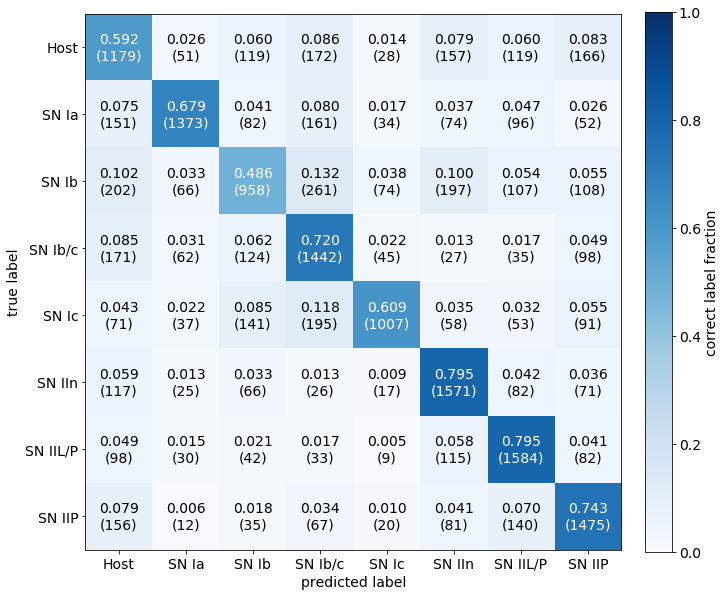

In [46]:
# CM
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_cv.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# Splitting in 70, 15, 15

In [56]:
x_train, x_test, x_cv,y_train, y_test, y_cv = split(0.7,x,y)
len(x_train), len(x_test), len(x_cv),len(y_train), len(y_test), len(y_cv)

(54593, 11699, 11698, 54593, 11699, 11698)

In [57]:
model = network((nbins, 1),ncat=y.shape[1])
hist = model.fit(x_train, y_train, batch_size=65, epochs=50, validation_data=(x_test, y_test), shuffle=True)

Train on 54593 samples, validate on 11699 samples
Epoch 1/50
54593/54593 [==============================] - 10s 182us/sample - loss: 2.0562 - acc: 0.5261 - val_loss: 1.5837 - val_acc: 0.6235
Epoch 2/50
54593/54593 [==============================] - 9s 166us/sample - loss: 1.4556 - acc: 0.6460 - val_loss: 1.3576 - val_acc: 0.6628
Epoch 3/50
54593/54593 [==============================] - 9s 165us/sample - loss: 1.2909 - acc: 0.6726 - val_loss: 1.2439 - val_acc: 0.6767
Epoch 4/50
54593/54593 [==============================] - 9s 166us/sample - loss: 1.1953 - acc: 0.6886 - val_loss: 1.1757 - val_acc: 0.6879
Epoch 5/50
54593/54593 [==============================] - 9s 166us/sample - loss: 1.1379 - acc: 0.6974 - val_loss: 1.1371 - val_acc: 0.6948
Epoch 6/50
54593/54593 [==============================] - 9s 165us/sample - loss: 1.0942 - acc: 0.7025 - val_loss: 1.1008 - val_acc: 0.6987
Epoch 7/50
54593/54593 [==============================] - 9s 165us/sample - loss: 1.0585 - acc: 0.7094 - val_

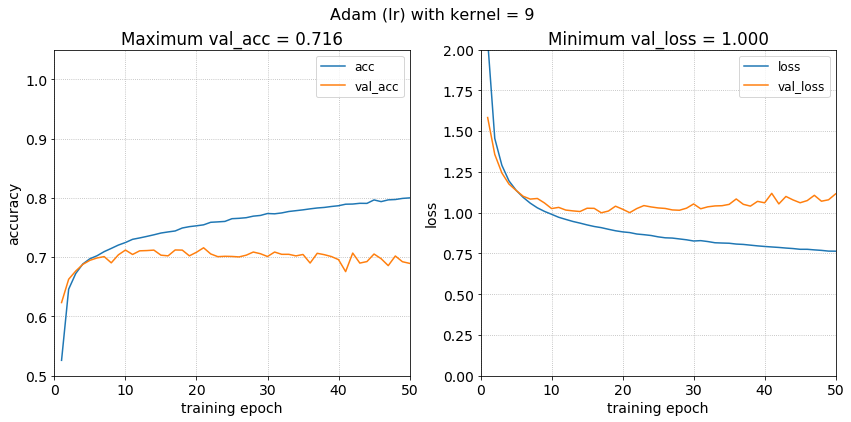

In [58]:
# Plotting epoch vs accuracy 
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
fig.suptitle(title, fontsize=16)
nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)
title = "Adam (lr) with kernel = {0}".format(n)
ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.set_title('Maximum val_acc = {0:2.3f}'.format(max(hist.history['val_acc'])))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.set_title('Minimum val_loss = {0:2.3f}'.format(min(hist.history['val_loss'])))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

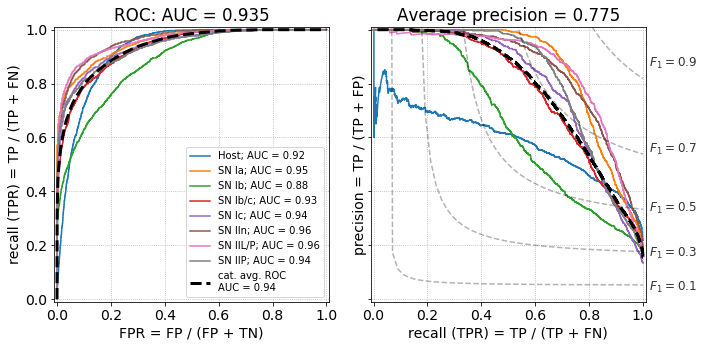

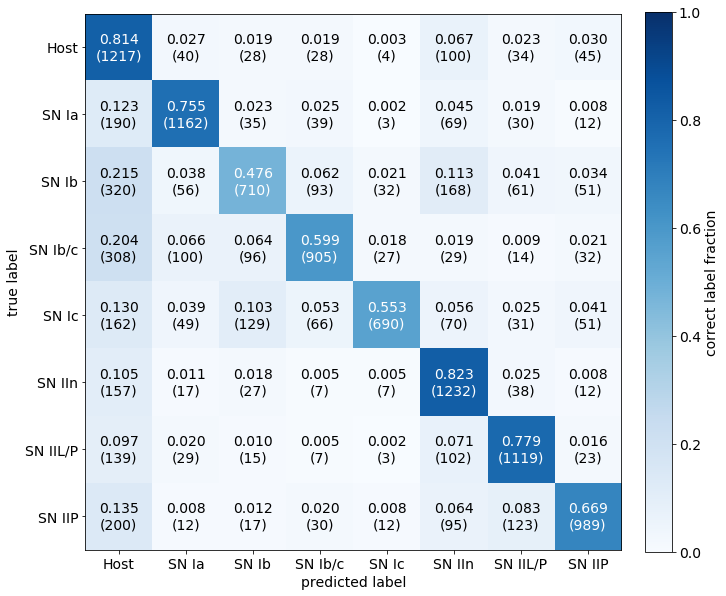

In [59]:
# Print ROC and PR Curve
y_pred = model.predict(x_cv)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_cv[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])

    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')

    pre[i], rec[i], _ = precision_recall_curve(y_cv[:,i], y_pred[:,i])

    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])

ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_cv.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_cv, y_pred)),
       aspect='equal')

fig.tight_layout()

# CM
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_cv.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()